#An attempted reproduction of the paper by Timothy O'Shea and Jakob Hoydis
IEEE Explore link: https://ieeexplore.ieee.org/abstract/document/8054694%5D

Quick setup, importing:

In [0]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K

Pick variables n and k, as dictated by the problem you want to solve. Unedited values are 2 and 2, for the most basic case considered in the paper. Set R and the training noise for use later.

In [0]:
n = 2
k = 4
M = 2**k
R = k/n
training_noise_ratio = 10**0.7
noise_mag = np.sqrt(1/(2*R*training_noise_ratio))
print(noise_mag)

0.22334179607548157


Create the input/output data. We want M categories

In [0]:
dat_size=M*10000
rand_data=np.random.randint(M,size=dat_size)
xs = keras.utils.to_categorical(rand_data)
print('verification checks:')
print(xs[2],'\n',xs[20],'\n',xs[200])


verification checks:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


Custom code for implementation of various attempts to get the right shape

In [0]:
class MaxEnergyConstraint(keras.layers.Layer):
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def call(self, inputs):
        energy=K.sum(K.square(inputs))
        if energy>4:
            outputs=inputs/K.sqrt(energy/4)
        else:
            outputs=inputs
        return outputs

#different solution, from https://stackoverflow.com/questions/48880221/layer-normalization-with-python-keras?rq=1
def norm_clip(x):
    return tf.clip_by_norm(x, 1, axes=[1])

Create the model. In order the layers are a the encoder, a dense with ReLU activation, a dense with linear activation and a batch-normalised layer (average power constraint); followed by the channel (a noise layer); then the decoder of a Dense with ReLU activation and a Dense with softmax activation.

In [0]:
autoenc_in = keras.layers.Input(shape=(M,))

encoder_0 = keras.layers.Dense(M,activation='relu')(autoenc_in)
#encoder_1 = keras.layers.Dense(M,activation='relu')(encoder_0)
# line to paste in for regularisation: , activity_regularizer=keras.regularizers.l2(10000)
encoder_2 = keras.layers.Dense(n,activation='linear')(encoder_0)
#encoder_3 = keras.layers.BatchNormalization(  )(encoder_2)
encoder_4 = keras.layers.BatchNormalization(center=False,scale=False)(encoder_2)
#encoder_4 = MaxEnergyConstraint()(encoder_2)
#encoder_4 = AverageEnergyConstraint()(encoder_2)
#encoder_4 = kerals.layers.Dense(n,activation=norm_clip)
#encoder_4 = keras.layers.Lambda(lambda x: K.l2_normalize(x,axis=-1))(encoder_2)

channel = keras.layers.GaussianNoise(noise_mag)(encoder_4)

decoder_0 = keras.layers.Dense(M,activation='relu')(channel)
#decoder_1 = keras.layers.Dense(M,activation='relu')(decoder_0)
decoder_2 = keras.layers.Dense(M,activation='softmax')(decoder_0)

autoenc = keras.models.Model(autoenc_in,decoder_2)
print (autoenc.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
_________________________________________________________________
batch_normalization_2 (Batch (None, 2)                 4         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272 

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.0003)
autoenc.compile(optimizer=adam, loss='categorical_crossentropy')

In [0]:
autoenc.fit(xs,xs,batch_size=1600,epochs=150)

Epoch 1/150
100/100 [==============================] - 0s 2ms/step - loss: 2.7843
Epoch 2/150
100/100 [==============================] - 0s 2ms/step - loss: 2.5485
Epoch 3/150
100/100 [==============================] - 0s 2ms/step - loss: 2.3562
Epoch 4/150
100/100 [==============================] - 0s 2ms/step - loss: 2.2088
Epoch 5/150
100/100 [==============================] - 0s 2ms/step - loss: 2.0769
Epoch 6/150
100/100 [==============================] - 0s 2ms/step - loss: 1.9552
Epoch 7/150
100/100 [==============================] - 0s 3ms/step - loss: 1.8440
Epoch 8/150
100/100 [==============================] - 0s 2ms/step - loss: 1.7401
Epoch 9/150
100/100 [==============================] - 0s 2ms/step - loss: 1.6426
Epoch 10/150
100/100 [==============================] - 0s 2ms/step - loss: 1.5491
Epoch 11/150
100/100 [==============================] - 0s 2ms/step - loss: 1.4605
Epoch 12/150
100/100 [==============================] - 0s 2ms/step - loss: 1.3793
Epoch 13/150


Define a model for the encoder so we can see outputs for the constellation. Define a model for the decoder so we can model BER.

In [0]:
encoder = keras.models.Model(autoenc_in,encoder_4)
#test=keras.models.Model(autoenc_in,encoder_2)
deco_in = keras.layers.Input(shape=(2,))
deco = autoenc.layers[-2](deco_in)
deco = autoenc.layers[-1](deco)
decoder = keras.models.Model(deco_in,deco)

Draw a constellation

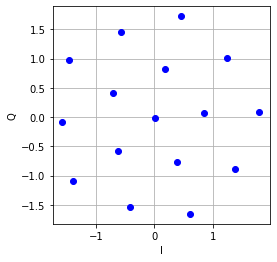

In [0]:
data = []
for i in range(0,M):
  temp = np.zeros(M)
  temp[i] = 1
  data.append(encoder.predict(np.expand_dims(temp,axis=0)))
data = np.array(data)
data = data.reshape(M,2,1)
plt.plot(data[:,0],data[:,1],'bo')
plt.grid()
plt.xlabel('I')
plt.ylabel('Q')
plt.axis('square')
plt.show()


In [0]:
#Calculate expected power usage (for equal usage of each symbol)
power_use=0
for iter1 in np.arange(M):
    symbol_energy=data[iter1,0,0]**2+data[iter1,1,0]**2
    power_use += symbol_energy/M
print(power_use)
scaling=np.sqrt(power_use)

1.9990342061785658


New model with scaling

In [0]:
encoder_5 = keras.layers.Lambda(lambda x: x/scaling)(encoder_4)

autoenc_sc = autoenc.layers[-3](encoder_5)
autoenc_sc = autoenc.layers[-2](autoenc_sc)
autoenc_sc = autoenc.layers[-1](autoenc_sc)
scaled_autoenc = keras.models.Model(autoenc_in,autoenc_sc)

print(scaled_autoenc.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
_________________________________________________________________
batch_normalization_2 (Batch (None, 2)                 4         
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                48  

Use a lower learning rate

In [0]:
#adam = keras.optimizers.Adam(learning_rate=0.0001)
#scaled_autoenc.compile(optimizer=adam, loss='categorical_crossentropy')

In [0]:
#scaled_autoenc.fit(xs,ys,epochs=16)

In [0]:
encoder_sc = keras.models.Model(autoenc_in, encoder_5)

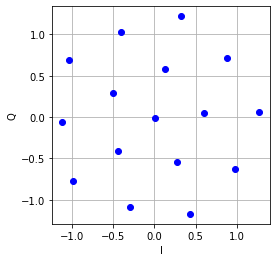

In [0]:
data = []
for i in range(0,M):
  temp = np.zeros(M)
  temp[i] = 1
  data.append(encoder_sc.predict(np.expand_dims(temp,axis=0)))
data = np.array(data)
data = data.reshape(M,2,1)
plt.plot(data[:,0],data[:,1],'bo')
plt.grid()
plt.xlabel('I')
plt.ylabel('Q')
plt.axis('square')
plt.show()

In [0]:
power_use=0
for iter1 in np.arange(M):
    symbol_energy=data[iter1,0,0]**2+data[iter1,1,0]**2
    power_use += symbol_energy/M
print(power_use)
#scaling=np.sqrt(power_use)

1.000000048155108


To measure the BER, use the data used for training. We need to scale the noise proportional to the energy of the scheme for fair comparison.

In [0]:
EbNo_range_dB = list(np.arange(0,21,2))
ber= [None]*len(EbNo_range_dB)
for iter1 in range(len(EbNo_range_dB)):
    EbNo = 10**(EbNo_range_dB[iter1]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))*scaling
    noise = noise_std*np.random.randn(dat_size,n)
    sig_in = encoder.predict(xs) + noise
    prediction = decoder.predict(sig_in)
    prediction = np.argmax(prediction,axis=1)
    wrong = (prediction != rand_data)
    count = np.sum(wrong)
    ber[iter1] = count/dat_size
    print('EbNo(dB):',EbNo_range_dB[iter1],'SER',ber[iter1])


EbNo(dB): 0 SER 0.62250625
EbNo(dB): 2 SER 0.521425
EbNo(dB): 4 SER 0.399475
EbNo(dB): 6 SER 0.2647
EbNo(dB): 8 SER 0.1433375
EbNo(dB): 10 SER 0.0565875
EbNo(dB): 12 SER 0.013175
EbNo(dB): 14 SER 0.0017375
EbNo(dB): 16 SER 5.625e-05
EbNo(dB): 18 SER 6.25e-06
EbNo(dB): 20 SER 0.0


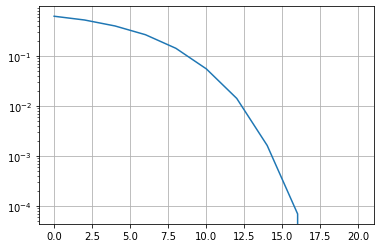

In [0]:
plt.plot(EbNo_range_dB,ber)
plt.yscale('log')
plt.grid()

In [0]:
print(np.sqrt(1/(2*R*EbNo))*scaling)
print(scaling)

0.07069360307302504
1.4138720614605007
